In [1]:
# This Source Code Form is subject to the terms of the Mozilla Public
# License, v. 2.0. If a copy of the MPL was not distributed with this
# file, You can obtain one at https://mozilla.org/MPL/2.0/.

# Vulnerabilidad frente al Covid19

**Autor Metodología**: Centro de la Producción del Espacio ([@CPE_UDLA](https://twitter.com/CPE_UDLA)).

**Autor del código**: Diego Caro ([@diegocaro](https://twitter.com/diegocaro)).

El objetivo de este notebook es contarles como procesar la información de hogares disponible en el Censo 2017. En particular, replicaremos el estudio [Índice de Vulnerabilidad Frente al Covid19](https://producciondelespacio.org/2020/03/31/vulnerabilidad-de-los-hogares-chilenos-de-cara-a-la-expansion-del-covid-19/) desarrollado por el [Centro de la Producción del Espacio](https://producciondelespacio.org).

**Descargo de responsabilidad**: este notebook no constituye información cartográfica oficial de la República de Chile. Su único fin es educativo, y no debe ser utilizada como referencia para decisiones oficiales sobre la pandemia.

**Reconocimiento**: este notebook está inspirado en el hermoso trabajo del [Centro de la Producción del Espacio](https://producciondelespacio.org), y muchas gracias por publicar metodología en Twitter https://twitter.com/CPE_UDLA/status/1245508375288348674.  

## Introducción
El Índice de Vulnerabilidad Frente al Covid19 del [Centro de la Producción del Espacio](https://producciondelespacio.org) está compuesto por 4 factores:
1. **Concentración de Adultos Mayores**: cantidad de adultos mayores por zona censal. Se considera adulto mayor a alguien cuya edad es de 60 o más años.
2. **Vulnerabilidad Socioeconómica Crítica**: cantidad de hogares en condición de vulnerabilidad socio-económica crítica. Esto se mide a partir del nivel de estudios de los o las jefas de hogar, considerando que un hogar comandado por una persona que solo tiene educación básica o no tiene educación formal, es más vulnerable económicamente.
3. **Precariedad de la Vivienda**: cantidad de viviendas precarias en tanto a su materialidad por zona censal.
4. **Hogares en Situación de Hacinamiento**: En esta pestaña se indica la cantidad de viviendas hacinadas según el Censo.  El hacinamiento es el número de personas que alojan en la vivienda divido el número de dormitorios que esta tiene. Se considera que un hogar en está en condición de hacinamiento cuando el número de dormitorios por persona es mayor o igual a 2,5.

## Preámbulo: descargando datos y módulos de Python

En esta celda configuramos el notebook para que muestre las figuras en alta resolución (y cargamos los mejores módulos de Python  ❤️).

In [2]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set(palette='viridis', context='notebook', font_scale=1.0, font='Avenir Next Condensed')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Usaremos los Microdatos del Censo 2017, que incluyen información a nivel de persona, hogar y vivienda. Los microdatos no están disponibles para descargar en la [web del INE](http://www.censo2017.cl/microdatos/) (debes [ir a buscar un DVD](https://geometadatos.wordpress.com/2018/07/08/especial-censo-2017/)). Sin embargo, los puedes bajar desde la cuenta [Google Drive](https://drive.google.com/drive/u/1/folders/12qIuycAHmXPDwqmtz4PB_ozfj1Wd9Zjn) del [Centro de Investigación del Arvo Shanpion](https://twitter.com/CiasShile). 
# 🐒

Los datos los descargué en mi computador, así que actualiza la variable `CENSUS_PATH` al directorio donde descargaste los microdatos.

In [3]:
import os
CENSUS_PATH = '/Users/diegocaro/datasets/Censo2017/Censo2017_Microdatos_CSV/'
PERS_FILE = os.path.join(CENSUS_PATH,'Microdato_Censo2017-Personas.csv')
VIVI_FILE = os.path.join(CENSUS_PATH,'Microdato_Censo2017-Viviendas.csv')
PERS_FILE, VIVI_FILE

('/Users/diegocaro/datasets/Censo2017/Censo2017_Microdatos_CSV/Microdato_Censo2017-Personas.csv',
 '/Users/diegocaro/datasets/Censo2017/Censo2017_Microdatos_CSV/Microdato_Censo2017-Viviendas.csv')

Para identificar las zonas censales en los microdatos del Censo usaremos las columnas COMUNA, DC (distrito), y ZC_LOC (identificador de zona). Las tres columnas representan una zona censal.

In [4]:
geo_cols = ['COMUNA','DC','ZC_LOC']

## Factores del hogar

En esta sección calcularemos los factores Concentración de Adultos Mayores y Vulnerabilidad Socioeconómica Crítica. Para esto usaremos los datos acerca de las personas.

De acuerdo al [Manual de Usuario del Censo 2017](http://www.censo2017.cl/microdatos/descargas/microdatos/Manual_de_usuario_Censo_2017_16R.pdf), las columnas P07, P10 y P15 representan:

- P07 es la relación de parentezco con jefa/e del hogar
- P09 es la edad
- P15 es el Nivel del curso más alto aprobado

Dado que la base de datos de personas contiene más de 17 millones de registros, solo cargaremos las columnas que necesitamos. La variable `geo_cols` indican las columans que identifican unívocamente la información de una Zona Censal.

In [5]:
# dtype=np.int16 es un truquillo para ahorrar memoria. 
# Recuerda que esta base de datos contiene más de 17millones de registros
# Con un computador de 4GB de RAM debería funcionar OK
personas = pd.read_csv(PERS_FILE, sep=';' , usecols=geo_cols+['P09','P15', 'P07'], dtype=np.int16)
personas.head()

,COMUNA,DC,ZC_LOC,P07,P09,P15
0,15202,1,6,1,73,6
1,15202,1,6,1,78,98
2,15202,1,6,2,78,98
3,15202,1,6,5,52,5
4,15202,1,6,11,44,5


In [6]:
personas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17574003 entries, 0 to 17574002
Data columns (total 6 columns):
 #   Column  Dtype
---  ------  -----
 0   COMUNA  int16
 1   DC      int16
 2   ZC_LOC  int16
 3   P07     int16
 4   P09     int16
 5   P15     int16
dtypes: int16(6)
memory usage: 201.1 MB


#### Cálculo concentración de adultos mayores

In [7]:
# le restaremos 3 años a la edad, para asumir los "nuevos" adultos mayores al año 2020
num_adultom = personas[(personas.P09 >= 60-3)].groupby(geo_cols).size().rename('adulto_mayor')
num_adultom

COMUNA  DC  ZC_LOC
1101    1   1         441
            2         151
        2   1         132
            2           3
            3         430
                     ... 
15202   3   10          6
            901        12
        4   13          9
            901         6
        99  999         1
Name: adulto_mayor, Length: 15074, dtype: int64

In [8]:
num_adultom.describe()

count    15074.000000
mean       229.152183
std        314.990357
min          1.000000
25%         16.000000
50%         55.000000
75%        383.000000
max       1603.000000
Name: adulto_mayor, dtype: float64

#### Cálculo de número de viviendias en situacion de vulnerabilidad socioeconómica crítica

La la columna P07 indica la Relación de parentezco con la jefa/e del hogar. Nos quedaremos con las filas cuyo valor sea igual a 1 (jefa/e de hogar).

La pregunta P15 indica Nivel del curso más alto aprobado, donde el valor 5 corresponde a Educación básica, y el valor 6 corresponde a Primaria o preparatorio (sistema antiguo).

In [9]:
jefashogar = personas[(personas.P07 == 1)]
1-jefashogar[jefashogar.P15 < 98].shape[0] / jefashogar.shape[0]

0.028482721024014834

In [10]:
gse_vulnerable = jefashogar[(jefashogar.P15 < 98)&(jefashogar.P15 <= 6)].groupby(geo_cols).size().rename('gse_vulnerable')
gse_vulnerable.head()

COMUNA  DC  ZC_LOC
1101    1   1          77
            2          12
        2   1          17
            2           6
            3         284
Name: gse_vulnerable, dtype: int64

In [11]:
gse_vulnerable.describe()

count    14883.000000
mean       101.256669
std        144.739165
min          1.000000
25%         11.000000
50%         34.000000
75%        130.000000
max       1272.000000
Name: gse_vulnerable, dtype: float64

## Factores sobre la vivienda

En esta sección trabajaremos en el cálculo de los factores Hogares en Situación de Hacinamiento y Precariedad de la Vivienda. Para esto cargaremos el archivo que contiene información sobre las viviendas.

De acuerdo al [Manual de Usuario del Censo 2017](http://www.censo2017.cl/microdatos/descargas/microdatos/Manual_de_usuario_Censo_2017_16R.pdf), las columnas P03A, P03B, P04 y CANT_PER representan:

- La columna P03A es el Material de los muros exteriores
- La columna P03B es el Material en la cubierta del techo
- La columna P04 es el número de piezas usadas exclusivamente como dormitorio
- La columna CANT_PER es la cantidad de personas en la vivienda
- La columna CANT_HOG es la cantidad de hogares en la vivivenda

In [12]:
viviendas = pd.read_csv(VIVI_FILE, sep=';', usecols=geo_cols+['P03A','P03B','P04', 'CANT_PER','CANT_HOG'], dtype=np.int16)
viviendas.head()

,COMUNA,DC,ZC_LOC,P03A,P03B,P04,CANT_HOG,CANT_PER
0,15202,1,6,5,3,1,1,1
1,15202,1,6,98,98,98,0,0
2,15202,1,6,5,3,2,1,4
3,15202,1,6,98,98,98,0,0
4,15202,1,6,98,98,98,0,0


In [13]:
viviendas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499574 entries, 0 to 6499573
Data columns (total 8 columns):
 #   Column    Dtype
---  ------    -----
 0   COMUNA    int16
 1   DC        int16
 2   ZC_LOC    int16
 3   P03A      int16
 4   P03B      int16
 5   P04       int16
 6   CANT_HOG  int16
 7   CANT_PER  int16
dtypes: int16(8)
memory usage: 99.2 MB


#### Cálculo viviendas de materiales precarios

De acuerdo al Manual de Usuario del Censo 2017, un valor igual a 6 en las columnas P03A y P03B indican que la vivienda es de material precario (lata, cartón, plástico, etc.).

In [14]:
material = viviendas[(viviendas.P03A == 6) | (viviendas.P03B == 6)].groupby(geo_cols).size().rename('material_precario')
material.head()

COMUNA  DC  ZC_LOC
1101    1   1          7
        2   1          4
            2          8
            3         23
            4         20
Name: material_precario, dtype: int64

In [15]:
material.describe()

count    8355.000000
mean        7.705326
std        16.000960
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
max       272.000000
Name: material_precario, dtype: float64

#### Cálculo hogares en situación de hacinamiento

La columna P04 contiene el número de personas por vivienda. Una vivienda se considera en condición de hacinamiento cuando existen al menos 2,5 personas por dormitorio (fuente: [Índice de Vulnerabilidad Frente al Covid19](https://producciondelespacio.org/2020/03/31/vulnerabilidad-de-los-hogares-chilenos-de-cara-a-la-expansion-del-covid-19/), [Centro de la Producción del Espacio](https://producciondelespacio.org)).

In [16]:
viviendas['hacinamiento'] = viviendas.CANT_PER / viviendas.P04
viviendas[viviendas['hacinamiento'] >= 2.5].shape[0] / viviendas.shape[0]

0.05992869686536379

In [17]:
hacinamiento = viviendas[viviendas['hacinamiento'] >= 2.5].groupby(geo_cols).size().rename('hacinamiento')
hacinamiento.head()

COMUNA  DC  ZC_LOC
1101    1   1          87
            2           6
        2   1          17
            2           8
            3         122
Name: hacinamiento, dtype: int64

In [18]:
hacinamiento.describe()

count    12432.000000
mean        31.331322
std         48.665567
min          1.000000
25%          2.000000
50%          8.000000
75%         41.000000
max        705.000000
Name: hacinamiento, dtype: float64

In [19]:
hacinamiento.shape[0]

12432

Cálculo de hogares por zona censal

In [20]:
hogares = viviendas[viviendas.CANT_HOG != 98].groupby(geo_cols).size().rename('hogares')
hogares.head()

COMUNA  DC  ZC_LOC
1101    1   1         1140
            2          515
        2   1          306
            2           23
            3          852
Name: hogares, dtype: int64

## Final!

Ahora reuniremos todos los cálculos que hicimos en un dataframe. La idea es unirlos utilizando el código de la zona censal de cada factor calculado.

In [21]:
indice = pd.concat([num_adultom, gse_vulnerable,material,hacinamiento, hogares], axis=1).fillna(0).astype(np.int)
indice.head()

adulto_mayor  gse_vulnerable  material_precario  \
COMUNA DC ZC_LOC                                                    
1101   1  1                441              77                  7   
          2                151              12                  0   
       2  1                132              17                  4   
          2                  3               6                  8   
          3                430             284                 23   

                  hacinamiento  hogares  
COMUNA DC ZC_LOC                         
1101   1  1                 87     1140  
          2                  6      515  
       2  1                 17      306  
          2                  8       23  
          3                122      852

Y lo guardamos!

In [22]:
indice.to_csv('./output/indice_vulnerabilidad.csv')

# Visualizaciones
Aprovecharemos los mapas que hice del Gran Santiago :)

In [23]:
urban_comunas = gpd.read_file('./output/urban_comunas.shp')
urban_zonas = gpd.read_file('./output/urban_zonas.shp').set_index(['COMUNA','DC','ZC_LOC'])

In [24]:
# este es un truquillo para agregar borde al texto
# más detalles en https://matplotlib.org/3.2.1/tutorials/advanced/patheffects_guide.html
import matplotlib.patheffects as path_effects

# configuracion para el estilo del texto
text_style = dict(horizontalalignment='center', fontsize=14, fontweight='bold'
                 ,color='white', fontstretch='condensed')
text_effects = [path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()]

# esta biblioteca ajusta el texto para que no se sobrelape
try:
    from adjustText import adjust_text
except:
    adjust_text = lambda *x,**y: x

In [25]:
def plot_zonas(df, column=None, title=None, legend=True, cmap='YlGnBu', scheme='quantiles'):
    ax = urban_zonas.join(df).plot(figsize=(20,20), linewidth=1, edgecolor='white', column=column, legend=legend, scheme=scheme, cmap=cmap)
    ax = urban_comunas.plot(linewidth=2, edgecolor='black', facecolor="none", ax=ax)

    texts = []
    for comuna, centroid in zip(urban_comunas['NOM_COMUNA'], urban_comunas.centroid):
        t = ax.text(centroid.x, centroid.y, comuna, **text_style)
        t.set_path_effects(text_effects)
        texts.append(t)
    adjust_text(texts, autoalign='y', lim=1)
    ax.set_title(title,fontsize=20)
    ax.axis('off')

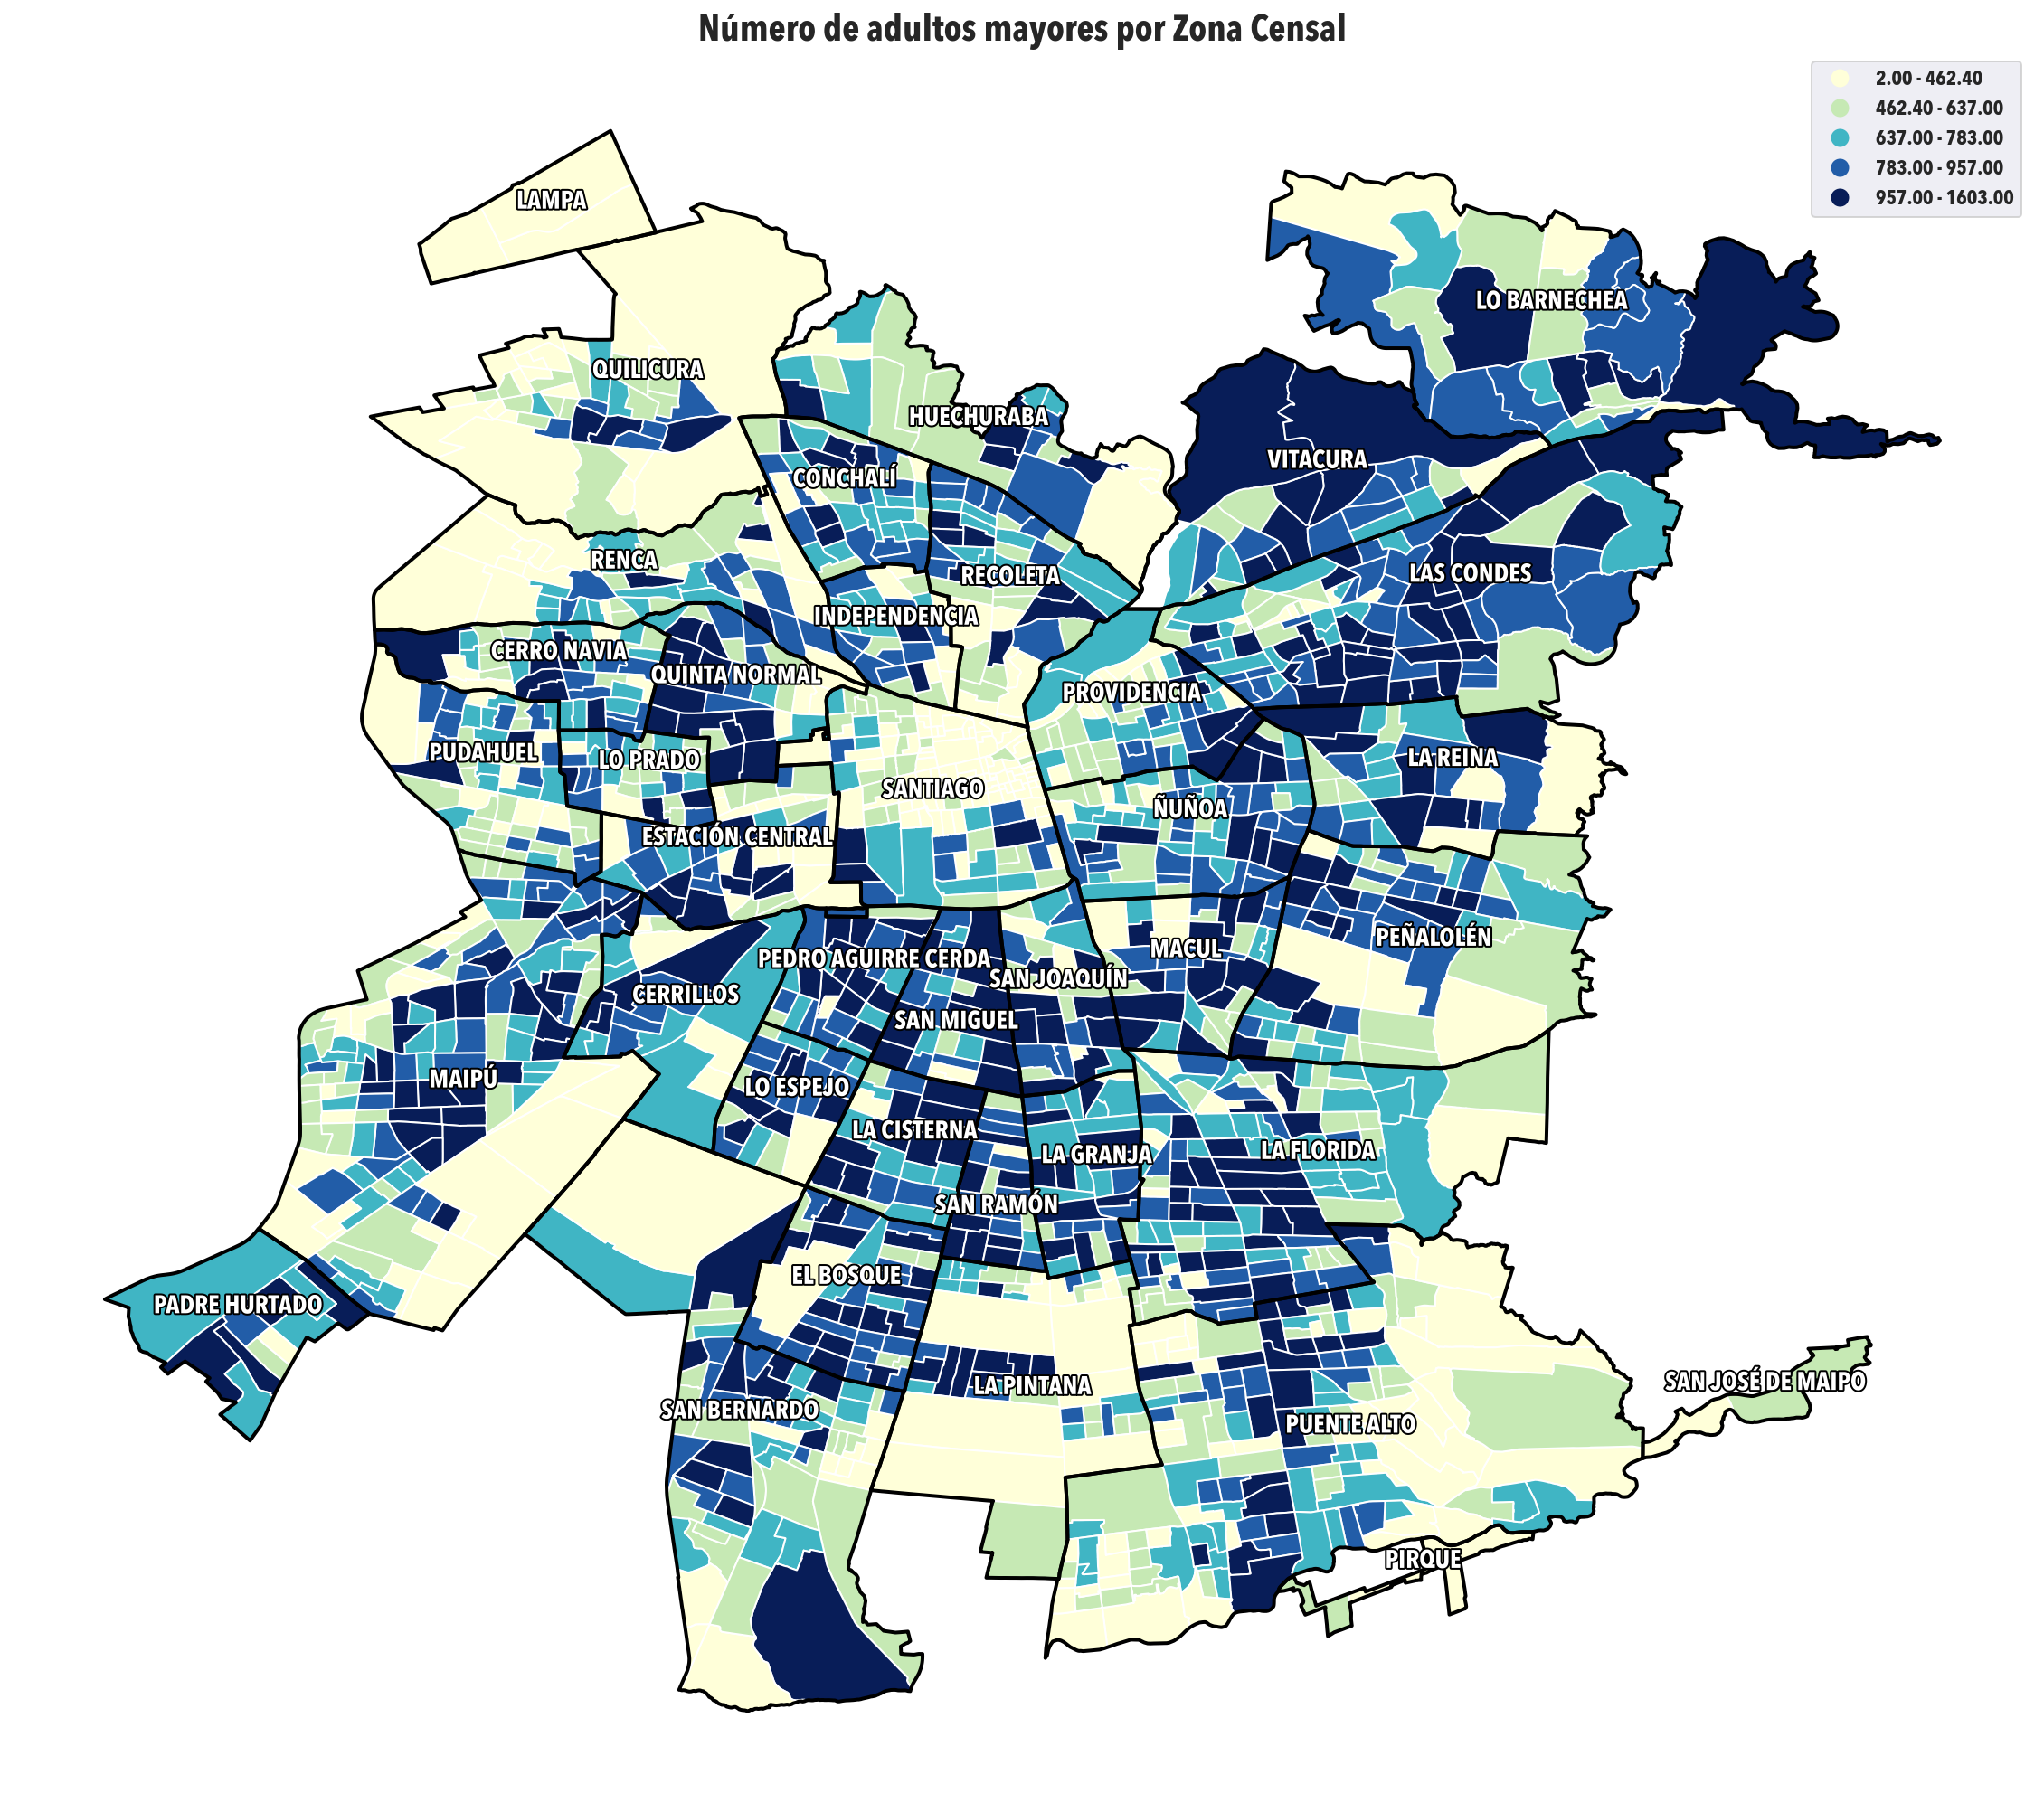

In [31]:
plot_zonas(indice, column='adulto_mayor', title='Número de adultos mayores por Zona Censal')
plt.savefig('images/vulnerable_adultos_mayores.png', dpi=150, bbox_inches='tight');

In [ ]:
plot_zonas(indice, column='gse_vulnerable', title='Número de hogares en condición de vulnerabilidad socioeconómica crítica por Zona Censal')
plt.savefig('images/vulnerable_gse.png', dpi=150, bbox_inches='tight');

In [ ]:
plot_zonas(indice, column='material_precario', title='Número de viviendas con material precario por Zona Censal')
plt.savefig('images/vulnerable_material_precario.png', dpi=150, bbox_inches='tight');

In [ ]:
plot_zonas(indice, column='hacinamiento', title='Número de hogares en condición de hacinamiento por Zona Censal')
plt.savefig('images/vulnerable_hacinamiento.png', dpi=150, bbox_inches='tight');